<a href="https://colab.research.google.com/github/marilynbraojos/transformer_demo/blob/main/gps2309.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit: Oliver S. from Toward Data Science

Note: This is not exactly what Oliver S. released and I've modified the way the notebook looks so that it can more closely match with my application of a transformer model (i.e. adding detailed comments, adjusting parameters, adding notes to refer to at a later time, plotting). However, he was the OG creator of this idea, therefore he deserves credit.

# Transformers Applied to Continuous Data

*The basic building blocks of a transformer are identical between continuous time series data and language modeling. The core difference is in the kinds of tokens used.*

## Encoder vs Decoder

*Encoder:* For each input token we attend over all other tokens in the input sequence to yield an accumulated value. This is processsed in a feed-forward layer. Repeat.


*Decoder:* In addition ot encoder functionality, we now also attend to token of the input sequence (self-attention and cross-attention). During self-attention, we need to mask the future tokens to avoid "cheating."

## Encoder

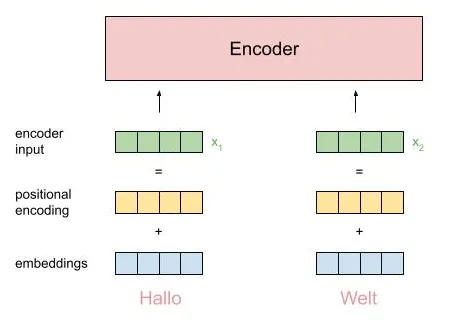

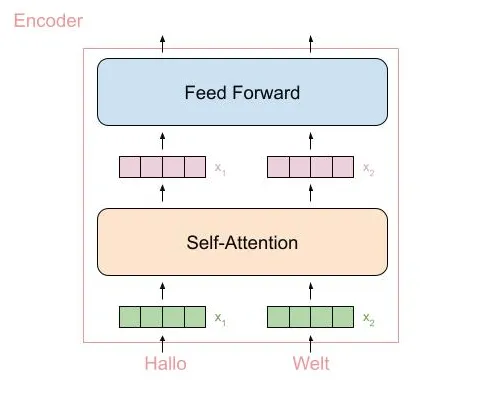

In *self-attention*, to represent our tokens, we need:
1. **Queries**
2. **Keys**
3. **Values**

Where, given one token as "query," the key values of all other tokens are used to determine its score. Then we mutiply this score by their values and aggregate.

Example: Suppose we want to compute the **values** of tokens with respect to token 1, we'd compute $q_1 × k_i$ for the rest of the tokens, $i$. Then we can multiply these scores as $v_i$ to obtain a processed value $z_1$.

In multi-head attention, we repeat that process N times and concatenate the result.

In the *feed-forward* block:

Fully connected layer that processes the output values of the previous step individually.

## Decoder

Same as encoder; stack self-attention and feed-forward blocks. Distinct from encoder in that:
- Atttend to all generated representation of the final encoder layer
- Mask values in self-attention to avoid attending to $i+1$ token when decoding token, $i$.

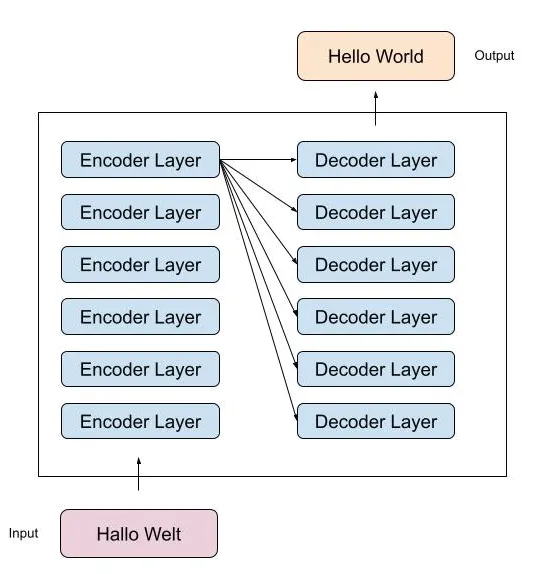

# Use Transformer to Predict Sine Function

**Problem Statement: Use a transformer model to predcit a noisy sine function**

In [4]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [14]:
data = np.load('correction_data.npz')
data

NpzFile 'correction_data.npz' with keys: indices, y

In [16]:
# Extract indices and 'y' (clock_correction) array from the loaded data
indices = data['indices']
indices

array([    0,     1,     2, ..., 32738, 32739, 32740], dtype=int32)

In [18]:
len(indices)

32741

In [20]:
clock_correction = data['y']
clock_correction

array([0.00017834, 0.00017834, 0.00017834, ..., 0.00017917, 0.00017917,
       0.00017917])

In [22]:
len(clock_correction)

32741

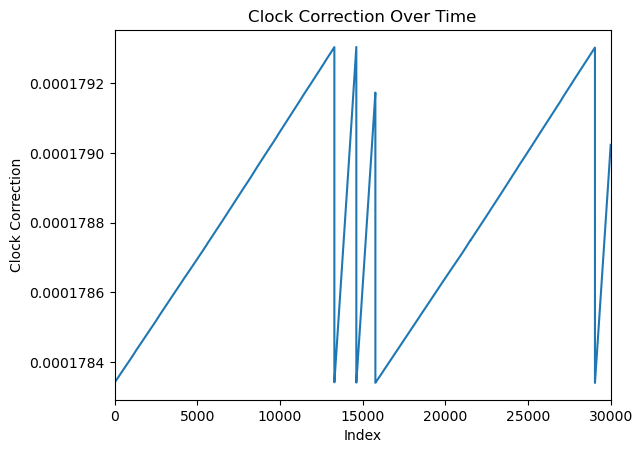

In [24]:
# Plotting with custom indices as x-axis
plt.plot(indices, clock_correction)
plt.xlabel('Index')
plt.ylabel('Clock Correction')
plt.title('Clock Correction Over Time')
plt.xlim(0, 30000)  # Adjust the x-axis limit as needed
plt.show()

In [26]:
n_replications = 3

In [28]:
y_replicated = np.tile(clock_correction, n_replications)
y_replicated

array([0.00017834, 0.00017834, 0.00017834, ..., 0.00017917, 0.00017917,
       0.00017917])

In [30]:
len(y_replicated)

98223

In [32]:
def extend_array(x, times):
    # Calculate the maximum value in x to determine the starting point for extension
    max_val = x[-1]
    
    # Create the extended array
    extended_x = np.arange(x[0], max_val + times * len(x) + 1)
    
    return extended_x

In [34]:
times = 2  # Number of times to extend the array (each full extension increases the length by len(x))
x_replicated = extend_array(indices, times)
x_replicated

array([    0,     1,     2, ..., 98220, 98221, 98222])

In [36]:
len(x_replicated)

98223

In [38]:
np.savez('replicated_file.npz', y=y_replicated)

In [40]:
data = np.load('replicated_file.npz')
data

NpzFile 'replicated_file.npz' with keys: y

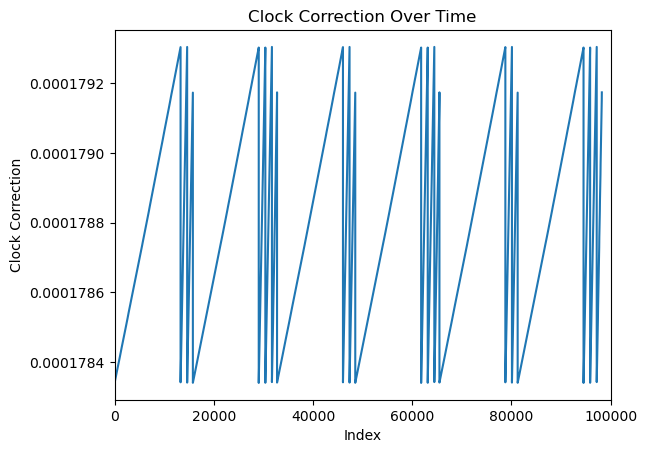

In [42]:
# Plotting with custom indices as x-axis
plt.plot(x_replicated, y_replicated)
plt.xlabel('Index')
plt.ylabel('Clock Correction')
plt.title('Clock Correction Over Time')
plt.xlim(0, 100000)  # Adjust the x-axis limit as needed
plt.show()

## Prepare Data

In [45]:
def split_sequence(
    sequence: np.ndarray, ratio: float = 0.8
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Splits a sequence into 2 (3) parts, as is required by our transformer
    model.

    Assume our sequence length is L, we then split this into src of length N
    and tgt_y of length M, with N + M = L.
    src, the first part of the input sequence, is the input to the encoder, and we
    expect the decoder to predict tgt_y, the second part of the input sequence.
    In addition we generate tgt, which is tgt_y but "shifted left" by one - i.e. it
    starts with the last token of src, and ends with the second-last token in tgt_y.
    This sequence will be the input to the decoder.


    Args:

        sequence: batched input sequences to split [bs, seq_len, num_features]
        ratio: split ratio, N = ratio * L

    Returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]: src, tgt, tgt_y
    """
    src_end = int(sequence.shape[1] * ratio)
    # [bs, src_seq_len, num_features]
    src = sequence[:, :src_end]
    # [bs, tgt_seq_len, num_features]
    tgt = sequence[:, src_end - 1 : -1]
    # [bs, tgt_seq_len, num_features]
    tgt_y = sequence[:, src_end:]

    return src, tgt, tgt_y

### Embedding, Positional Encoding, and Masking

Before feeding out input data into the transformer, we need to map our 1-D sine signal to a higher dimension. This is called embedding. We will be doing this by using a linear layer.



```
embedding = torch.nn.Linear(
    in_features=in_dim, out_features=embed_dim
)

seq = embedding(seq)```



Apply positional encoding (implementations available through PyTorch)

In [51]:
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html,
# only modified to account for "batch first"

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000) -> None:
      """
      Args:
        d_model (int): Dimension of the model (embedding dimension)
        dropout (float, optional): Dropout probability. Default is 0.1.
        max_len (int, optional): Maximum length of input sequences. Default is 5000.

      Attributes:
        pe (torch.Tensor): Positional encoding tensor. Shape: (1, max_len, d_model)

      Returns:
        torch.Tensor: input tensor with added positional encoding.

      """
      super().__init__()
      self.dropout = torch.nn.Dropout(p=dropout)

      position = torch.arange(max_len).unsqueeze(1)                           # 1-D tensor from 0 to max_len -1. Unsqueeze "adds" a superficial 1 dim.
      div_term = torch.exp(
          torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
      )
      pe = torch.zeros(1, max_len, d_model)
      pe[0, :, 0::2] = torch.sin(position * div_term)
      pe[0, :, 1::2] = torch.cos(position * div_term)
      self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      """Adds positional encoding to the given tensor.

      Args:
          x: tensor to add PE to [bs, seq_len, embed_dim]

      Returns:
          torch.Tensor: tensor with PE [bs, seq_len, embed_dim]
      """
      x = x + self.pe[:, : x.size(1)]
      return self.dropout(x)

For the decoder blocks, the same is applied with an added mask to avoid looking into future timesteps.



```
# Generate mask to avoid attention to future outputs.
# [tgt_seq_len, tgt_seq_len]
tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])
# Embed decoder input and add positional encoding.
# [bs, tgt_seq_len, embed_dim]
tgt = self.decoder_embedding(tgt)
tgt = self.positional_encoding(tgt)```



## Build Model

This model is created leveraging PyTorch's transformer module.


```
self.transformer = torch.nn.Transformer(nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers, d_model=embed_dim, batch_first=True)


'''
Args:
  Number of heads
  Number of encoder/decoder layers
  Embed/Feature Dims
  Inputs/Outputs
'''
```



In [57]:
class TransformerWithPE(torch.nn.Module):
    def __init__(
        self, in_dim: int, out_dim: int, embed_dim: int, num_heads: int, num_layers: int
    ) -> None:
        """
        Initializes a transformer model with positional encoding.

        Args:
            in_dim: number of input features
            out_dim: number of features to predict
            embed_dim: embed features to this dimension
            num_heads: number of transformer heads
            num_layers: number of encoder and decoder layers
        """
        super().__init__()

        self.positional_encoding = PositionalEncoding(embed_dim)

        # transform input features into embedded features
        self.encoder_embedding = torch.nn.Linear(
            in_features=in_dim, out_features=embed_dim
        )
        self.decoder_embedding = torch.nn.Linear(
            in_features=out_dim, out_features=embed_dim
        )

        # map output into output dimension
        self.output_layer = torch.nn.Linear(in_features=embed_dim, out_features=out_dim)


        self.transformer = torch.nn.Transformer(
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            d_model=embed_dim,
            batch_first=True,
        )

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        """Forward function of the model.

        Args:
            src: input sequence to the encoder [bs, src_seq_len, num_features]
            tgt: input sequence to the decoder [bs, tgt_seq_len, num_features]

        Returns:
            torch.Tensor: predicted sequence [bs, tgt_seq_len, feat_dim]
        """
        # if self.train:
        # Add noise to decoder inputs during training
        # tgt = tgt + torch.normal(0, 0.1, size=tgt.shape).to(tgt.device)

        # Embed encoder input and add positional encoding.
        # [bs, src_seq_len, embed_dim]
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        # Generate mask to avoid attention to future outputs.
        # [tgt_seq_len, tgt_seq_len]
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])
        # Embed decoder input and add positional encoding.
        # [bs, tgt_seq_len, embed_dim]
        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        # Get prediction from transformer and map to output dimension.
        # [bs, tgt_seq_len, embed_dim]
        pred = self.transformer(src, tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)

        return pred                                                             # return predicted sequence


    def infer(self, src: torch.Tensor, tgt_len: int) -> torch.Tensor:
        """Runs inference with the model, meaning: predicts future values
        for an unknown sequence.
        For this, iteratively generate the next output token while
        feeding the already generated ones as input sequence to the decoder.

        Args:
            src: input to the encoder [bs, src_seq_len, num_features]
            tgt_len: desired length of the output

        Returns:
            torch.Tensor: inferred sequence
        """
        output = torch.zeros((src.shape[0], tgt_len + 1, src.shape[2])).to(src.device)
        output[:, 0] = src[:, -1]
        for i in range(tgt_len):
            output[:, i + 1] = self.forward(src, output)[:, i]

        return output[:, 1:]

## Load and Partition Data

In [60]:
def load_and_partition_data(
    data_path: Path, seq_length: int = 100
) -> tuple[np.ndarray, int]:
    """Loads the given data and paritions it into sequences of equal length.

    Args:
        data_path: path to the dataset
        sequence_length: length of the generated sequences

    Returns:
        tuple[np.ndarray, int]: tuple of generated sequences and number of
            features in dataset
    """
    data = np.load(data_path)
    num_features = len(data.keys())

    # Check that each feature provides the same number of data points
    data_lens = [len(data[key]) for key in data.keys()]
    assert len(set(data_lens)) == 1

    num_sequences = data_lens[0] // seq_length
    sequences = np.empty((num_sequences, seq_length, num_features))

    for i in range(0, num_sequences):
        # [sequence_length, num_features]
        sample = np.asarray(
            [data[key][i * seq_length : (i + 1) * seq_length] for key in data.keys()]
        ).swapaxes(0, 1)
        sequences[i] = sample

    return sequences, num_features


def make_datasets(sequences: np.ndarray) -> tuple[TensorDataset, TensorDataset]:
    """Create train and test dataset.

    Args:
        sequences: sequences to use [num_sequences, sequence_length, num_features]

    Returns:
        tuple[TensorDataset, TensorDataset]: train and test dataset
    """
    # Split sequences into train and test split
    train, test = train_test_split(sequences, test_size=0.2)
    return TensorDataset(torch.Tensor(train)), TensorDataset(torch.Tensor(test))


def visualize(
    src: torch.Tensor,
    tgt: torch.Tensor,
    pred: torch.Tensor,
    pred_infer: torch.Tensor,
    idx=0,
) -> None:
    """Visualizes a given sample including predictions.

    Args:
        src: source sequence [bs, src_seq_len, num_features]
        tgt: target sequence [bs, tgt_seq_len, num_features]
        pred: prediction of the model [bs, tgt_seq_len, num_features]
        pred_infer: prediction obtained by running inference
            [bs, tgt_seq_len, num_features]
        idx: batch index to visualize
    """
    plt.clf()

    x = np.arange(src.shape[1] + tgt.shape[1])
    src_len = src.shape[1]

    plt.plot(x[:src_len], src[idx].cpu().detach(), "bo-", label="src")
    plt.plot(x[src_len:], tgt[idx].cpu().detach(), "go-", label="tgt")
    plt.plot(x[src_len:], pred[idx].cpu().detach(), "ro-", label="pred")
    plt.plot(x[src_len:], pred_infer[idx].cpu().detach(), "yo-", label="pred_infer")

    plt.legend()
    plt.show()


def split_sequence(
    sequence: np.ndarray, ratio: float = 0.8
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Splits a sequence into 2 (3) parts, as is required by our transformer
    model.

    Assume our sequence length is L, we then split this into src of length N
    and tgt_y of length M, with N + M = L.
    src, the first part of the input sequence, is the input to the encoder, and we
    expect the decoder to predict tgt_y, the second part of the input sequence.
    In addition we generate tgt, which is tgt_y but "shifted left" by one - i.e. it
    starts with the last token of src, and ends with the second-last token in tgt_y.
    This sequence will be the input to the decoder.


    Args:
        sequence: batched input sequences to split [bs, seq_len, num_features]
        ratio: split ratio, N = ratio * L

    Returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]: src, tgt, tgt_y
    """
    src_end = int(sequence.shape[1] * ratio)
    # [bs, src_seq_len, num_features]
    src = sequence[:, :src_end]
    # [bs, tgt_seq_len, num_features]
    tgt = sequence[:, src_end - 1 : -1]
    # [bs, tgt_seq_len, num_features]
    tgt_y = sequence[:, src_end:]

    return src, tgt, tgt_y


def move_to_device(device: torch.Tensor, *tensors: torch.Tensor) -> list[torch.Tensor]:
    """Move all given tensors to the given device.

    Args:
        device: device to move tensors to
        tensors: tensors to move

    Returns:
        list[torch.Tensor]: moved tensors
    """
    moved_tensors = []
    for tensor in tensors:
        if isinstance(tensor, torch.Tensor):
            moved_tensors.append(tensor.to(device))
        else:
            moved_tensors.append(tensor)
    return moved_tensors

## Define Parameters and Run Model

In [63]:
BS = 15                                                                         # batch size
FEATURE_DIM = 128                                                               # dimensionality of input features
NUM_HEADS = 8                                                                   # number of attention heads in the multi-head attention mechanism
NUM_EPOCHS = 20                                                                 # number of times entire dataset is passed for training
NUM_VIS_EXAMPLES = 1
NUM_LAYERS = 2                                                                  # number of encoder and decoder layers in the mdel
LR = 0.001                                                                      # learning rate

In [107]:
# Load data and generate train and test datasets / dataloaders
sequences, num_features = load_and_partition_data("replicated_file.npz", 5000)  # change data file name
train_set, test_set = make_datasets(sequences)
train_loader, test_loader = DataLoader(
    train_set, batch_size=BS, shuffle=True
), DataLoader(test_set, batch_size=BS, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [109]:
# Initialize model, optimizer and loss criterion
model = TransformerWithPE(
    num_features, num_features, FEATURE_DIM, NUM_HEADS, NUM_LAYERS
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

In [111]:
%%time

# Train loop
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0                                                           # initialize epoch loss
    for batch in train_loader:
        optimizer.zero_grad()

        src, tgt, tgt_y = split_sequence(batch[0])
        src, tgt, tgt_y = move_to_device(device, src, tgt, tgt_y)
        # [bs, tgt_seq_len, num_features]
        pred = model(src, tgt)
        loss = criterion(pred, tgt_y)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(
        f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: "
        f"{(epoch_loss / len(train_loader)):.4f}"
    )

Epoch [1/20], Loss: 3.8592
Epoch [2/20], Loss: 0.1172
Epoch [3/20], Loss: 0.0527
Epoch [4/20], Loss: 0.0251
Epoch [5/20], Loss: 0.0129
Epoch [6/20], Loss: 0.0090
Epoch [7/20], Loss: 0.0079
Epoch [8/20], Loss: 0.0074
Epoch [9/20], Loss: 0.0069
Epoch [10/20], Loss: 0.0066
Epoch [11/20], Loss: 0.0062
Epoch [12/20], Loss: 0.0062
Epoch [13/20], Loss: 0.0060
Epoch [14/20], Loss: 0.0058
Epoch [15/20], Loss: 0.0057
Epoch [16/20], Loss: 0.0056
Epoch [17/20], Loss: 0.0054
Epoch [18/20], Loss: 0.0052
Epoch [19/20], Loss: 0.0050
Epoch [20/20], Loss: 0.0049
CPU times: user 31min 32s, sys: 49min 10s, total: 1h 20min 42s
Wall time: 39min 52s


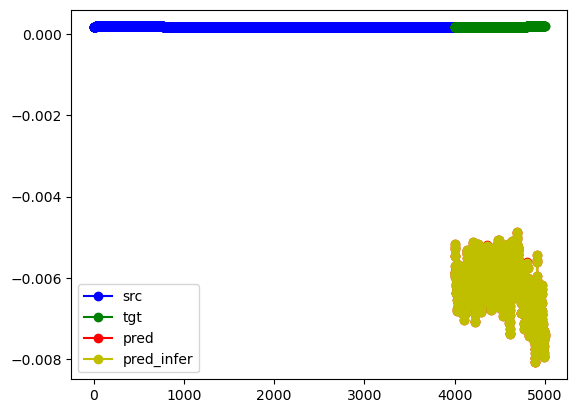

Eval Loss on test set: 0.0000
CPU times: user 1h 51min 10s, sys: 1h 24min 44s, total: 3h 15min 55s
Wall time: 27min 8s


In [114]:
%%time
# Evaluate model
model.eval()
eval_loss = 0.0
infer_loss = 0.0

with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        src, tgt, tgt_y = split_sequence(batch[0])
        src, tgt, tgt_y = move_to_device(device, src, tgt, tgt_y)

        # [bs, tgt_seq_len, num_features]
        pred = model(src, tgt)
        loss = criterion(pred, tgt_y)
        eval_loss += loss.item()

        # Run inference with model
        pred_infer = model.infer(src, tgt.shape[1])
        loss_infer = criterion(pred_infer, tgt_y)
        infer_loss += loss_infer.item()

        if idx < NUM_VIS_EXAMPLES:
            visualize(src, tgt, pred, pred_infer)

avg_eval_loss = eval_loss / len(test_loader)
avg_infer_loss = infer_loss / len(test_loader)

print(f"Eval Loss on test set: {avg_eval_loss:.4f}")